In [21]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle

    
with open('language_editors.pkl', 'rb') as x:
    language_activities = pickle.load(x)

print("El diccionario language_activities ha sido cargado correctamente.")

# Diccionario de números para cada categoría
category_dict = {
    'art': 1,
    'events': 2,
    'foods': 3,
    'games': 4,
    'geography': 5,
    'health': 6,
    'history': 7,
    'mathematics': 8,
    'nature': 9,
    'philosophy': 10,
    'politics': 11,
    'religion': 12,
    'rights': 13,
    'sports': 14
}


data_list = []
for language, categories_data in language_activities.items():
    for category, activity in categories_data.items():
        category_number = category_dict[category]
        for (day_of_week, hour), edits in activity.items():
            # Crear una columna que represente la hora de la semana
            week_hour = day_of_week * 24 + hour
            data_list.append([language, category_number, week_hour, edits])

data = pd.DataFrame(data_list, columns=['language', 'category', 'week_hour', 'edits'])

# Pivotar el DataFrame para que cada hora de la semana sea una columna y cada fila sea una combinación de idioma y categoría
data_pivot = data.pivot_table(index=['language'], columns=['week_hour', 'category'], values='edits', fill_value=0)

# Normalizar los datos utilizando z-score
scaler = StandardScaler()
#data_scaled = scaler.fit_transform(data_pivot)




El diccionario language_activities ha sido cargado correctamente.


In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Turn the dataframe into a numpy object
df = data_pivot.values

In [24]:
from sklearn.preprocessing import StandardScaler
# Supongamos que df es tu DataFrame o array de numpy
data = df  # Si df ya es un numpy array, no necesitas convertirlo

# Normalización de los datos usando StandardScaler
# scaler = StandardScaler()
# data = scaler.fit_transform(data)

In [25]:
data

array([[  810,   591,    77, ...,   589,   357,   330],
       [10550,  2753,     0, ...,  4351,  3846,  3710],
       [14509, 12582,     0, ...,  5147, 15442,  6072],
       ...,
       [ 2324,  1491,   237, ...,  1206,  1125,   924],
       [  214,   237,    20, ...,   124,    94,    71],
       [ 2528,   959,   185, ...,   885,   837,   645]])

In [7]:
df.shape

(11, 2352)

In [26]:
n_input_layer = df.shape[1]
n_hidden1 = 30
n_hidden2 = 15
n_hidden3 = 15

n_encoding_layer = 10

n_hidden5 = 15
n_hidden6 = 15
n_hidden7 = 30
n_output_layer = n_input_layer  # of course, the output layer must be of the same size of the input layer
     

In [27]:

# Placeholders are kind of "empty variables" in a TF computational graph.
# I will feed the actual data through them - in the graph, they are like entry doors for my data

#X = tf.placeholder(tf.float32, shape = [None, df.shape[1]], name='X')
X = tf.keras.layers.Input(shape=(df.shape[1],), name='X')

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
# Definición de la arquitectura del autoencoder
input_layer = Input(shape=(n_input_layer,), name="input_layer")
hidden1 = Dense(n_hidden1, activation=tf.nn.leaky_relu, name="hidden_layer1")(input_layer)
hidden2 = Dense(n_hidden2, activation=tf.nn.leaky_relu, name="hidden_layer2")(hidden1)
hidden3 = Dense(n_hidden3, activation=tf.nn.leaky_relu, name="hidden_layer3")(hidden2)
encoding_layer = Dense(n_encoding_layer, activation=tf.nn.leaky_relu, name="encoding_layer")(hidden3)
hidden5 = Dense(n_hidden5, activation=tf.nn.leaky_relu, name="hidden_layer5")(encoding_layer)
hidden6 = Dense(n_hidden6, activation=tf.nn.leaky_relu, name="hidden_layer6")(hidden5)
hidden7 = Dense(n_hidden7, activation=tf.nn.leaky_relu, name="hidden_layer7")(hidden6)
output_layer = Dense(n_output_layer, activation=tf.nn.leaky_relu, name="output_layer")(hidden7)

In [29]:
# set number of epochs
n_epochs = 5000

# set learning rate
learning_rate = 0.001

In [30]:
# implement Mean Squared Error
loss = tf.reduce_mean(tf.square(X - output_layer))

In [31]:
from tensorflow.keras.models import Model
# Define the TensorFlow operation that trains the model
#training_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
# Construcción del modelo autoencoder
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Definir el optimizador y compilar el modelo
autoencoder.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mean_squared_error')

In [32]:
# Guardar solo los pesos del modelo
autoencoder.save_weights('Encoder.h5')

In [33]:
print(autoencoder.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2352)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 30)                70590     
                                                                 
 hidden_layer2 (Dense)       (None, 15)                465       
                                                                 
 hidden_layer3 (Dense)       (None, 15)                240       
                                                                 
 encoding_layer (Dense)      (None, 10)                160       
                                                                 
 hidden_layer5 (Dense)       (None, 15)                165       
                                                                 
 hidden_layer6 (Dense)       (None, 15)                240 

In [34]:
data

array([[  810,   591,    77, ...,   589,   357,   330],
       [10550,  2753,     0, ...,  4351,  3846,  3710],
       [14509, 12582,     0, ...,  5147, 15442,  6072],
       ...,
       [ 2324,  1491,   237, ...,  1206,  1125,   924],
       [  214,   237,    20, ...,   124,    94,    71],
       [ 2528,   959,   185, ...,   885,   837,   645]])

In [35]:
from tensorflow.keras.callbacks import Callback
# Callback para monitorear la pérdida
class LossHistory(Callback):
    def on_train_begin(self, logs=None):
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        # if epoch % 100 == 0:
        #     print(f"{epoch+1}. Loss: {logs.get('loss')},")

loss_history = LossHistory()

# Entrenamiento del modelo con el callback
history=autoencoder.fit(data, data, epochs=n_epochs, batch_size=256, shuffle=True, callbacks=[loss_history])

# Guardar el modelo completo
autoencoder.save('autoencoder_model_standarizadaeditors.h5')

# Extracción de la parte del encoder para la reducción de dimensionalidad
encoder = Model(inputs=input_layer, outputs=encoding_layer)

# Transformación de los datos
encoded_data = encoder.predict(data)


print("Encoding complete.")

Epoch 1/5000
1/1 [==============================] - 0s 176ms/step - loss: 16740758.0000
Epoch 2/5000
1/1 [==============================] - 0s 3ms/step - loss: 16318071.0000
Epoch 3/5000
1/1 [==============================] - 0s 2ms/step - loss: 15686422.0000
Epoch 4/5000
1/1 [==============================] - 0s 3ms/step - loss: 14884038.0000
Epoch 5/5000
1/1 [==============================] - 0s 3ms/step - loss: 13910697.0000
Epoch 6/5000
1/1 [==============================] - 0s 3ms/step - loss: 12834095.0000
Epoch 7/5000
1/1 [==============================] - 0s 3ms/step - loss: 11744008.0000
Epoch 8/5000
1/1 [==============================] - 0s 3ms/step - loss: 10758385.0000
Epoch 9/5000
1/1 [==============================] - 0s 2ms/step - loss: 9983999.0000
Epoch 10/5000
1/1 [==============================] - 0s 3ms/step - loss: 9339983.0000
Epoch 11/5000
1/1 [==============================] - 0s 3ms/step - loss: 8585487.0000
Epoch 12/5000
1/1 [==============================] - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 2ms/step - loss: 20960.6934
Epoch 1342/5000
1/1 [==============================] - 0s 2ms/step - loss: 21113.8691
Epoch 1343/5000
1/1 [==============================] - 0s 2ms/step - loss: 20441.7832
Epoch 1344/5000
1/1 [==============================] - 0s 2ms/step - loss: 19942.5332
Epoch 1345/5000
1/1 [==============================] - 0s 2ms/step - loss: 20012.8926
Epoch 1346/5000
1/1 [==============================] - 0s 2ms/step - loss: 20182.5234
Epoch 1347/5000
1/1 [==============================] - 0s 2ms/step - loss: 20352.3359
Epoch 1348/5000
1/1 [==============================] - 0s 2ms/step - loss: 20118.4297
Epoch 1349/5000
1/1 [==============================] - 0s 2ms/step - loss: 19619.9980
Epoch 1350/5000
1/1 [==============================] - 0s 2ms/step - loss: 19520.5508
Epoch 1351/5000
1/1 [==============================] - 0s 2ms/step - loss: 19750.3633
Epoch 1352/5000
1/1 [==============================] - 0s 2ms/step - l

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 2ms/step - loss: 5074.3096
Epoch 2781/5000
1/1 [==============================] - 0s 2ms/step - loss: 5117.5527
Epoch 2782/5000
1/1 [==============================] - 0s 2ms/step - loss: 5219.5439
Epoch 2783/5000
1/1 [==============================] - 0s 2ms/step - loss: 5081.0928
Epoch 2784/5000
1/1 [==============================] - 0s 2ms/step - loss: 5134.7051
Epoch 2785/5000
1/1 [==============================] - 0s 2ms/step - loss: 5063.1709
Epoch 2786/5000
1/1 [==============================] - 0s 2ms/step - loss: 5010.6143
Epoch 2787/5000
1/1 [==============================] - 0s 2ms/step - loss: 5004.4536
Epoch 2788/5000
1/1 [==============================] - 0s 2ms/step - loss: 4956.3906
Epoch 2789/5000
1/1 [==============================] - 0s 2ms/step - loss: 4969.2705
Epoch 2790/5000
1/1 [==============================] - 0s 2ms/step - loss: 4947.7798
Epoch 2791/5000
1/1 [==============================] - 0s 2ms/step - loss: 4939.6

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 2ms/step - loss: 1215.7200
Epoch 4233/5000
1/1 [==============================] - 0s 2ms/step - loss: 1206.6790
Epoch 4234/5000
1/1 [==============================] - 0s 2ms/step - loss: 1266.8877
Epoch 4235/5000
1/1 [==============================] - 0s 2ms/step - loss: 1453.7919
Epoch 4236/5000
1/1 [==============================] - 0s 2ms/step - loss: 1660.7777
Epoch 4237/5000
1/1 [==============================] - 0s 2ms/step - loss: 1836.2443
Epoch 4238/5000
1/1 [==============================] - 0s 2ms/step - loss: 2032.4933
Epoch 4239/5000
1/1 [==============================] - 0s 2ms/step - loss: 2440.9893
Epoch 4240/5000
1/1 [==============================] - 0s 2ms/step - loss: 2980.9529
Epoch 4241/5000
1/1 [==============================] - 0s 2ms/step - loss: 3753.4172
Epoch 4242/5000
1/1 [==============================] - 0s 2ms/step - loss: 4532.6431
Epoch 4243/5000
1/1 [==============================] - 0s 2ms/step - loss: 5550.2

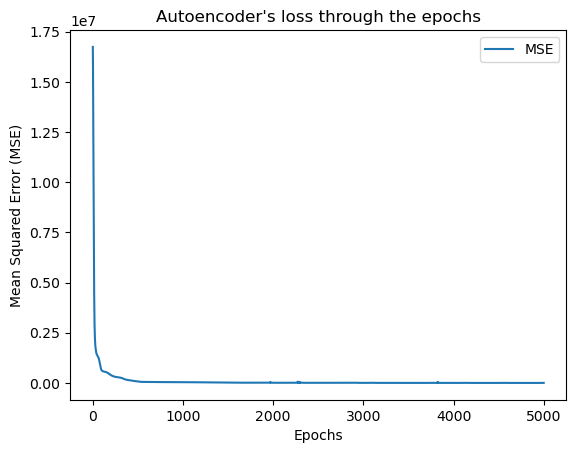

In [36]:
# Graficar la pérdida a lo largo de las épocas
plt.plot(loss_history.losses, label="MSE")
plt.title("Autoencoder's loss through the epochs")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.show()

In [37]:
# You can save it in a pandas dataframe
encoded_pandas_dataframe = pd.DataFrame(encoded_data)

# Let's take a look:
encoded_pandas_dataframe.describe()

,0,1,2,3,4,5,6,7,8,9
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,-8723.133789,98273.343750,-23885.507812,82030.367188,-10656.009766,-13101.505859,-16605.708984,122062.671875,112616.203125,-13051.238281
std,12265.090820,81545.484375,26155.583984,92451.812500,7781.173828,11032.366211,18215.929688,134377.437500,87075.718750,13610.944336
min,-39557.484375,7517.149902,-92975.648438,-1785.811768,-25424.365234,-38261.730469,-62249.105469,10693.232422,9226.273438,-48400.082031
25%,-11920.613281,30613.575195,-27109.697266,16507.187012,-15175.804199,-19027.847656,-20753.118164,35730.589844,51726.810547,-13294.368652
50%,-5063.190918,82801.046875,-12846.108398,27411.638672,-9211.378906,-9440.227539,-8824.893555,60674.941406,72056.515625,-9321.240234
75%,-2547.252319,164078.585938,-7992.686035,149538.218750,-4676.579102,-6612.106445,-4021.375854,156429.968750,186857.460938,-3865.012329
max,8415.795898,242373.156250,-2237.331299,268114.468750,-1236.048584,-1129.596924,-1077.958008,473813.562500,270483.593750,-1347.084351


In [38]:
encoded_pandas_dataframe

,0,1,2,3,4,5,6,7,8,9
0,-2926.964355,17107.216797,-4912.854492,8630.057617,-2737.610840,-2485.953857,-2548.176025,23149.636719,19507.476562,-2817.289062
1,-3081.217041,242373.156250,-24077.044922,186276.125000,-25424.365234,-38261.730469,-23014.519531,119612.093750,270483.593750,-12940.252930
2,-16617.003906,190263.921875,-92975.648438,268114.468750,-8305.289062,-7564.471191,-62249.105469,473813.562500,205341.953125,-48400.082031
3,-5063.190918,174590.734375,-29488.218750,115155.718750,-13734.725586,-17820.015625,-18491.716797,161271.625000,169852.687500,-13648.484375
4,-2167.540283,28329.904297,-4850.000977,24384.316406,-4375.854492,-5659.741699,-3223.391357,21075.910156,39773.714844,-3280.495850
5,8415.795898,82801.046875,-11072.517578,61257.632812,-4977.303711,-7851.031250,-8824.893555,60674.941406,72056.515625,-4449.528809
6,-39557.484375,115440.679688,-24731.175781,-1785.811768,-21151.189453,-20235.679688,-17983.078125,151588.312500,116844.539062,-12669.533203
7,-12257.694336,153566.437500,-44027.636719,183920.718750,-16616.882812,-23906.605469,-33349.714844,215096.250000,203862.234375,-25728.205078
8,-11583.532227,36119.398438,-12846.108398,25081.134766,-9211.378906,-9440.227539,-7080.894043,57402.230469,63679.906250,-8961.431641
9,-1374.517822,7517.149902,-2237.331299,3888.027832,-1236.048584,-1129.596924,-1077.958008,10693.232422,9226.273438,-1347.084351


In [39]:
import pandas as pd

# Supongamos que encoded_pandas_dataframe es tu DataFrame actual
encoded_pandas_dataframe = pd.DataFrame(encoded_data)

# Lista de nuevos índices de fila
new_index = ['ar', 'de', 'es', 'fr', 'hu', 'it', 'ja', 'pt', 'ru', 'vi', 'zh']

# Asegúrate de que el tamaño del índice coincida con el número de filas en el DataFrame
if len(new_index) == encoded_pandas_dataframe.shape[0]:
    encoded_pandas_dataframe.index = new_index
else:
    raise ValueError("El tamaño del índice nuevo no coincide con el número de filas en el DataFrame")

# Mostrar el DataFrame con los nuevos índices
print(encoded_pandas_dataframe)

               0              1             2              3             4  \
ar  -2926.964355   17107.216797  -4912.854492    8630.057617  -2737.610840   
de  -3081.217041  242373.156250 -24077.044922  186276.125000 -25424.365234   
es -16617.003906  190263.921875 -92975.648438  268114.468750  -8305.289062   
fr  -5063.190918  174590.734375 -29488.218750  115155.718750 -13734.725586   
hu  -2167.540283   28329.904297  -4850.000977   24384.316406  -4375.854492   
it   8415.795898   82801.046875 -11072.517578   61257.632812  -4977.303711   
ja -39557.484375  115440.679688 -24731.175781   -1785.811768 -21151.189453   
pt -12257.694336  153566.437500 -44027.636719  183920.718750 -16616.882812   
ru -11583.532227   36119.398438 -12846.108398   25081.134766  -9211.378906   
vi  -1374.517822    7517.149902  -2237.331299    3888.027832  -1236.048584   
zh  -9741.122070   32897.246094 -11522.074219   27411.638672  -9445.464844   

               5             6              7              8   

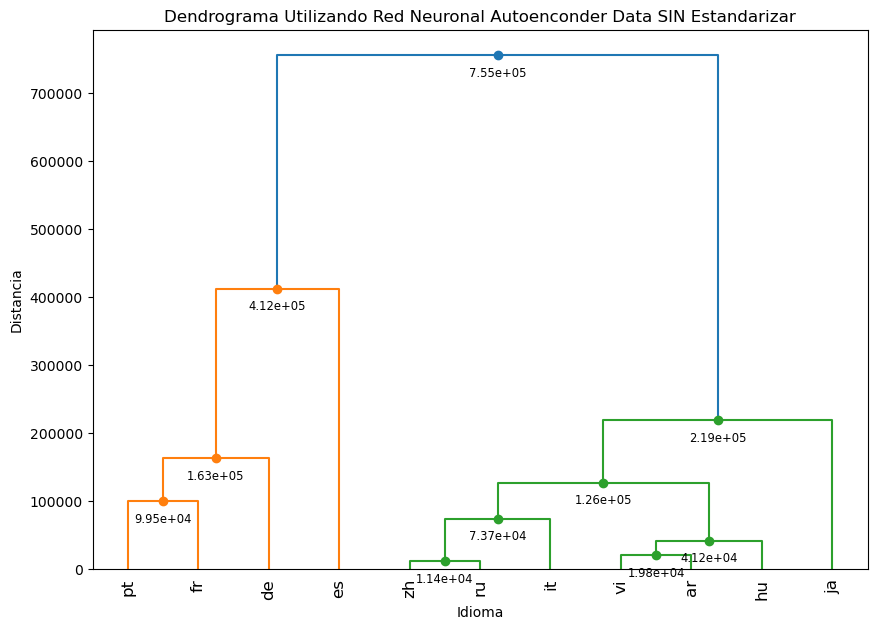

In [40]:
# Realizar la clusterización jerárquica
linked = linkage(encoded_pandas_dataframe, method='ward')

# Crear etiquetas para cada fila basadas en el idioma
labels = encoded_pandas_dataframe.index.tolist()

# Generar el dendrograma y capturar la salida para acceder a las coordenadas de los enlaces
plt.figure(figsize=(10, 7))
dendro = dendrogram(linked,
                    labels=labels,
                    distance_sort='descending',
                    show_leaf_counts=True)

# Añadir anotaciones de distancia
for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
    x = 0.5 * sum(i[1:3])
    y = d[1]
    if y > 0:  # Solo añadir etiquetas por encima de la línea cero para claridad
        plt.plot(x, y, 'o', c=c)
        plt.annotate(f"{y:.3g}", (x, y), xytext=(0, -8),
                     textcoords='offset points', va='top', ha='center', fontsize='small')
plt.title('Dendrograma Utilizando Red Neuronal Autoenconder Data SIN Estandarizar')
plt.xlabel('Idioma')
plt.ylabel('Distancia')
plt.xticks(rotation=90)
plt.savefig('editores/dendrogram8.png')
plt.show()